<a href="https://colab.research.google.com/github/umeshrawat/MLE/blob/master/Regression_Bike_Sharing_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import KFold
pd.set_option('display.max_colwidth', None)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Read Data From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Read the Excel file, skipping the first row and using the second row as the header
data = pd.read_csv("/content/drive/MyDrive/dataset/bike-sharing-demand/train.csv", header=0)

Notice here -

Casual +   Registered = Count
which is not present in the test set , so these 2 features columns can not be used directly

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


https://www.kaggle.com/competitions/bike-sharing-demand/overview

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields

datetime - hourly date + timestamp

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [ ]:
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


# EDA

## Count of bikes rented per hour

In [ ]:
data["datetime"] = pd.to_datetime(data["datetime"])
data["hour"] = data["datetime"].dt.hour
data["day_of_week"] = data["datetime"].dt.dayofweek
data["month"] = data["datetime"].dt.month
data["year"] = data["datetime"].dt.year
data["datetime"].dt.day.value_counts().sort_index()

1     575
2     573
3     573
4     574
5     575
6     572
7     574
8     574
9     575
10    572
11    568
12    573
13    574
14    574
15    574
16    574
17    575
18    563
19    574
Name: datetime, dtype: int64

In [ ]:
# test_df = pd.read_csv("/content/drive/MyDrive/dataset/bike-sharing-demand/test.csv", header=0)
# test_df['datetime'] = pd.to_datetime(test_df['datetime'])
# test_df['datetime'].dt.day.value_counts().sort_index()

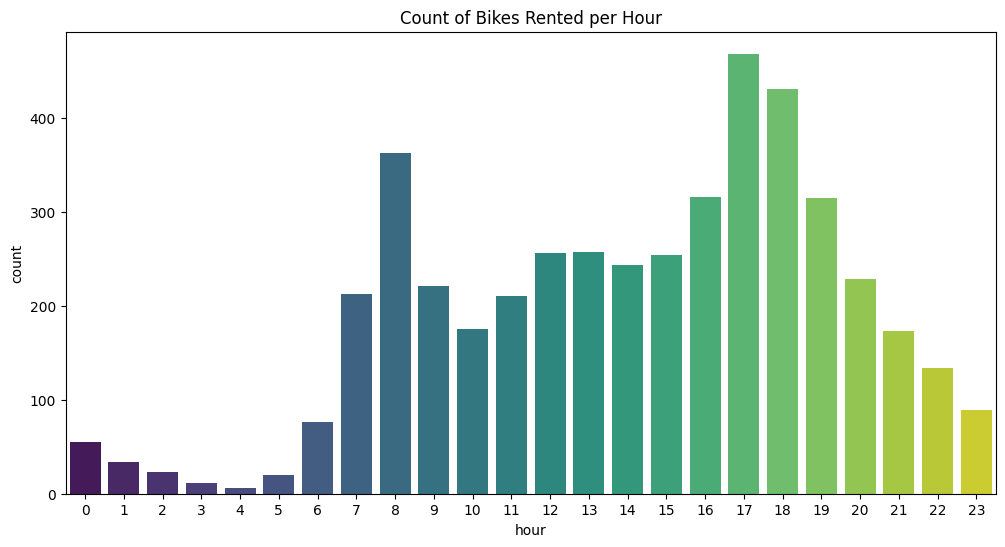

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x='hour', y='count', data=data.groupby('hour')['count'].mean().reset_index(), palette='viridis')
plt.title('Count of Bikes Rented per Hour')
plt.show()

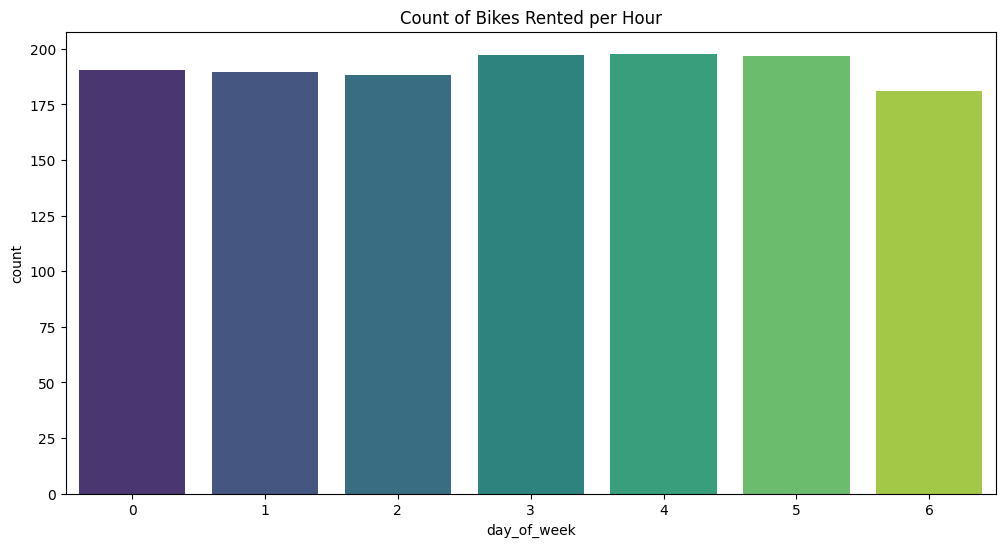

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x='day_of_week', y='count', data=data.groupby('day_of_week')['count'].mean().reset_index(), palette='viridis')
plt.title('Count of Bikes Rented per Hour')
plt.show()

## Count of bikes rented per month

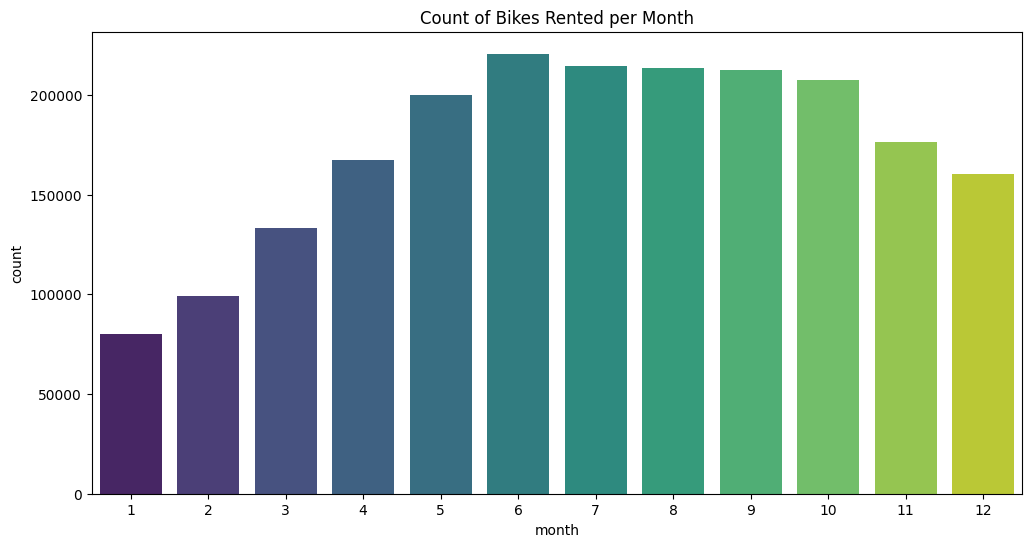

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x='month', y='count', data=data.groupby('month')['count'].sum().reset_index(), palette='viridis')
plt.title('Count of Bikes Rented per Month')
plt.show()

## Counts of Bikes rented by season

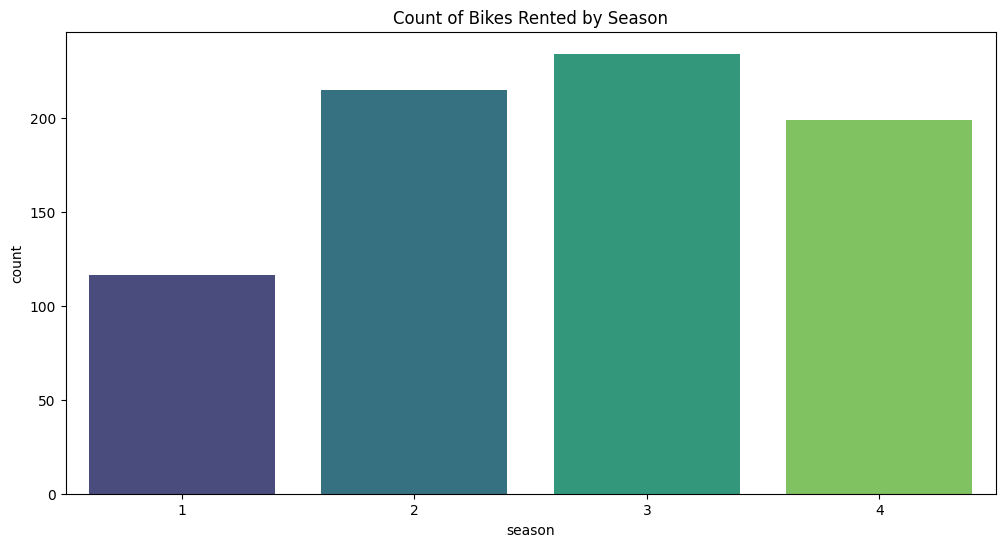

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x='season', y='count', data=data.groupby('season')['count'].mean().reset_index(), palette='viridis')
plt.title('Count of Bikes Rented by Season')
plt.show()

## Count of bikes rented in different weather conditions

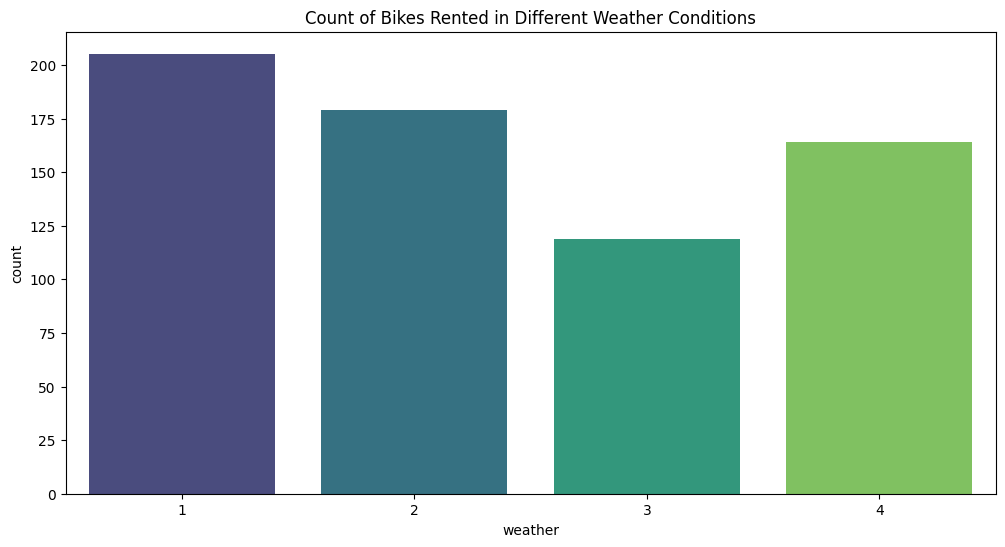

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x='weather', y='count', data=data.groupby('weather')['count'].mean().reset_index(), palette='viridis')
plt.title('Count of Bikes Rented in Different Weather Conditions')
plt.show()


## Corelation Heatmap

In [ ]:
data.corr()

<ipython-input-24-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_week,month,year
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,-0.006546,-0.010553,0.971524,-0.004797
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,-0.000354,-0.191832,0.001731,0.012021
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,0.002780,-0.704267,-0.003394,-0.002482
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.022740,-0.047692,0.012144,-0.012548
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.145430,-0.038466,0.257589,0.061226
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.140343,-0.040235,0.264173,0.058540
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.278011,-0.026507,0.204537,-0.078606
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,0.146631,-0.024804,-0.150192,-0.015221
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.302045,0.246959,0.092722,0.145241
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.380540,-0.084427,0.169451,0.264265


<ipython-input-29-75ee9b43a8fb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=.5)


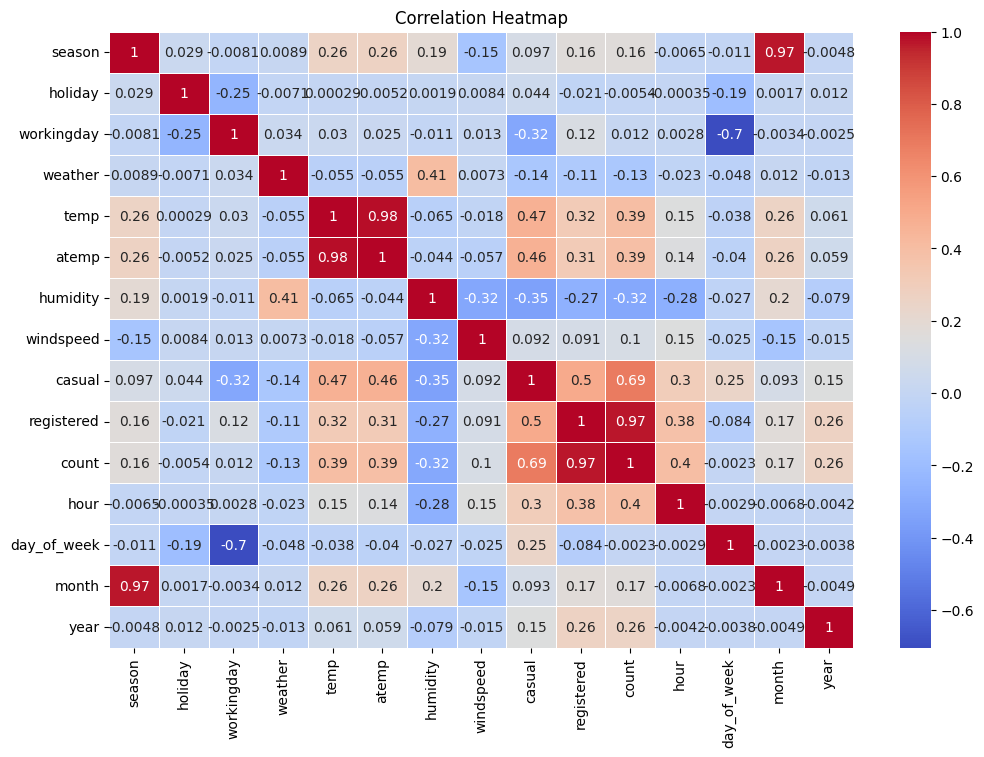

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

look for the count row in the graph , count of the bike is highly correlated with tempreature

See how season and Month are highly corrleated ,

# Feature Engineering

## Train Test split

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     10886 non-null  datetime64[ns]
 1   season       10886 non-null  int64         
 2   holiday      10886 non-null  int64         
 3   workingday   10886 non-null  int64         
 4   weather      10886 non-null  int64         
 5   temp         10886 non-null  float64       
 6   atemp        10886 non-null  float64       
 7   humidity     10886 non-null  int64         
 8   windspeed    10886 non-null  float64       
 9   casual       10886 non-null  int64         
 10  registered   10886 non-null  int64         
 11  count        10886 non-null  int64         
 12  hour         10886 non-null  int64         
 13  day_of_week  10886 non-null  int64         
 14  month        10886 non-null  int64         
 15  year         10886 non-null  int64         
dtypes: d

In [ ]:
data.isna().sum()

datetime       0
season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
casual         0
registered     0
count          0
hour           0
day_of_week    0
month          0
year           0
dtype: int64

In [ ]:
# Filter the data for the 18th and 19th day of each month
test_data = data[data['datetime'].dt.day.isin([18, 19])]

# Filter the data for all other days
train_data = data[~data['datetime'].dt.day.isin([18, 19])]


In [ ]:
len(train_data), len(test_data)

(9749, 1137)

In [ ]:
test_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_week,month,year
396,2011-01-18 12:00:00,1,0,1,2,8.20,9.090,86,22.0028,0,3,3,12,1,1,2011
397,2011-01-18 13:00:00,1,0,1,2,8.20,9.850,86,15.0013,0,22,22,13,1,1,2011
398,2011-01-18 14:00:00,1,0,1,2,9.02,11.365,80,11.0014,2,26,28,14,1,1,2011
399,2011-01-18 15:00:00,1,0,1,2,9.02,11.365,87,11.0014,3,32,35,15,1,1,2011
400,2011-01-18 16:00:00,1,0,1,2,9.02,11.365,87,12.9980,0,61,61,16,1,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,2,12,2012
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,2,12,2012
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,2,12,2012
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,2,12,2012


## Create DateTime Features

In [ ]:
# Preprocess the training dataset (e.g., converting dates, extracting features, etc.)
train_data = train_data.copy()  # Create a copy of the DataFrame
train_data["datetime"] = pd.to_datetime(train_data["datetime"])
train_data["hour"] = train_data["datetime"].dt.hour
train_data["day_of_week"] = train_data["datetime"].dt.dayofweek
train_data["month"] = train_data["datetime"].dt.month
train_data["year"] = train_data["datetime"].dt.year

# Preprocess the testing dataset (e.g., converting dates, extracting features, etc.)
test_data = test_data.copy()  # Create a copy of the DataFrame
test_data["datetime"] = pd.to_datetime(test_data["datetime"])
test_data["hour"] = test_data["datetime"].dt.hour
test_data["day_of_week"] = test_data["datetime"].dt.dayofweek
test_data["month"] = test_data["datetime"].dt.month
test_data["year"] = test_data["datetime"].dt.year

In [ ]:
train_data.isna().sum(), test_data.isna().sum()

(datetime       0
 season         0
 holiday        0
 workingday     0
 weather        0
 temp           0
 atemp          0
 humidity       0
 windspeed      0
 casual         0
 registered     0
 count          0
 hour           0
 day_of_week    0
 month          0
 year           0
 dtype: int64,
 datetime       0
 season         0
 holiday        0
 workingday     0
 weather        0
 temp           0
 atemp          0
 humidity       0
 windspeed      0
 casual         0
 registered     0
 count          0
 hour           0
 day_of_week    0
 month          0
 year           0
 dtype: int64)

In [ ]:
target = train_data["count"]

In [ ]:
# Define the features and target variable for testing data
features = train_data.drop(["datetime", "count"], axis=1).columns


In [ ]:
features

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'hour', 'day_of_week',
       'month', 'year'],
      dtype='object')


 ## Categorical Feature Handling

In [ ]:
# One-Hot Encoding for categorical features
categorical_features = ["hour", "day_of_week", "month", "year", "season", "holiday", "workingday", "weather"]
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoder.fit(train_data[categorical_features])

OneHotEncoder(drop='first', sparse_output=False)

In [ ]:
train_encoded = encoder.transform(train_data[categorical_features])
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_features))
# Reset index before concatenating
train_data = train_data.drop(categorical_features, axis=1).reset_index(drop=True)
train_encoded_df = train_encoded_df.reset_index(drop=True)
train_data = pd.concat([train_data, train_encoded_df], axis=1)

In [ ]:
test_encoded = encoder.transform(test_data[categorical_features])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_features))
# Reset index before concatenating
test_data = test_data.drop(categorical_features, axis=1).reset_index(drop=True)
test_encoded_df = test_encoded_df.reset_index(drop=True)
test_data = pd.concat([test_data, test_encoded_df], axis=1)

In [ ]:
train_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9749 entries, 0 to 9748
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       9749 non-null   datetime64[ns]
 1   temp           9749 non-null   float64       
 2   atemp          9749 non-null   float64       
 3   humidity       9749 non-null   int64         
 4   windspeed      9749 non-null   float64       
 5   casual         9749 non-null   int64         
 6   registered     9749 non-null   int64         
 7   count          9749 non-null   int64         
 8   hour_1         9749 non-null   float64       
 9   hour_2         9749 non-null   float64       
 10  hour_3         9749 non-null   float64       
 11  hour_4         9749 non-null   float64       
 12  hour_5         9749 non-null   float64       
 13  hour_6         9749 non-null   float64       
 14  hour_7         9749 non-null   float64       
 15  hour_8         9749 n

(None, None)

# Model Training

In [ ]:
def display_null_columns(data):
    null_columns = data.columns[data.isnull().any()]
    print("Columns with null values:")
    for col in null_columns:
        print(f"{col}: {data[col].isnull().sum()} null values")


In [ ]:
def display_null_rows(data):
    null_rows = data[data.isnull().any(axis=1)]
    print("Rows with null values:")
    print(null_rows[:5])


Casual + Registered  = count

So it would be feature leakage , remove those as well

In [ ]:
# Define the features and target variable for testing data
features = train_data.drop(["datetime", "count", "casual", "registered", "atemp", "season_2", "season_3", "season_4"], axis=1).columns
features, len(features)

(Index(['temp', 'humidity', 'windspeed', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
        'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
        'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
        'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
        'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
        'day_of_week_5', 'day_of_week_6', 'month_2', 'month_3', 'month_4',
        'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
        'month_11', 'month_12', 'year_2012', 'holiday_1', 'workingday_1',
        'weather_2', 'weather_3', 'weather_4'],
       dtype='object'),
 49)

In [ ]:
X_train = train_data[features]
y_train = train_data["count"]
X_test = test_data[features]
y_test = test_data["count"]

In [ ]:
# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Make predictions on the test set
y_pred = np.maximum(0, model.predict(X_test))
# y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmsle = mean_squared_log_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Root Mean Squared Logarithmic Error:", rmsle)
print("R-squared:", r2)

Mean Squared Error: 9262.261932277166
Root Mean Squared Error: 96.24064594690316
Root Mean Squared Logarithmic Error: 1.1356658656576242
R-squared: 0.7038252292060573


# Summary

Best hyperparameters found: {'alpha': 1, 'solver': 'auto'}

Mean Squared Error: 9602.842519361067

Root Mean Squared Error: 97.9940943085912

R-squared: 0.6929346521468052
